##Look at the hourly data

Now on to the real challenge, the hourly data. So, as usual, make some plots, do a bit of anaalysis and try to get a feel for the data.

###Remaining TO DO:
* Try preprocessing - standardizing the features, which I really should do....
* Try one hot encoder with days of the week (each day should be treated as a separate feature instead of a continuous one)
  * When doing this, can get rid of 'working day' feature
* Fit independently to the 'casual' and 'registered' values as targets, and then when we do predict, sum the two predictions to compare to the test values - this is probably only useful/effective for certain estimators
* Evaluate the estimators
* Clean up the plots and make them look nicer 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
hourly = pd.read_csv('Bike-Sharing-Dataset/hour.csv',header = 0)

In [3]:
hourly.head(20)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In [4]:
type(hourly)
for row_index, row in hourly.iterrows():
    
    print row_index ,  row['registered']
    if (row_index > 5):
        break


0 13
1 32
2 27
3 10
4 1
5 1
6 0


In [5]:
weekly = np.zeros((24,7))
for row_index, row in hourly.iterrows():
    weekly[row['hr'], row['weekday']] += row['registered']

In [6]:
print np.max(weekly)

50883.0


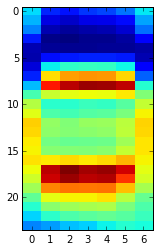

In [7]:
plt.imshow(np.sqrt(weekly/np.max(weekly)), interpolation='nearest', aspect=0.5)

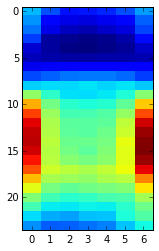

In [8]:
weekly = np.zeros((24,7))
for row_index, row in hourly.iterrows():
    weekly[row['hr'], row['weekday']] += row['casual']
plt.imshow(np.sqrt(weekly/np.max(weekly)), interpolation='nearest', aspect=0.5)

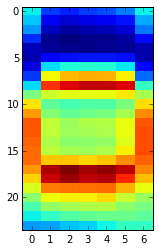

In [9]:
weekly = np.zeros((24,7))
for row_index, row in hourly.iterrows():
    weekly[row['hr'], row['weekday']] += row['cnt']
plt.imshow(np.sqrt(weekly/np.max(weekly)), interpolation='nearest', aspect=0.5)

###It's quite clear that registered and casual users are very different

I already knew this from analyzing the daily data, but this shows that registered riders tend to commute, while casual riders joy ride on the weekends. And, if you look closely, you can see that registered users tend to head out of work a bit earlier on fridays. To get the best model, we'll need to include weekday (which we may want to put through one-hot encoder first).

###Get ready for ML

I want to use the training/test cut that Kaggle does, so need to put the day of the month into the column, and then drop the unnecessary columns

In [10]:
hourly['day'] =  pd.DatetimeIndex(hourly.dteday).day
hourly = hourly.drop(['instant','dteday','casual','registered'], axis = 1)

In [11]:
Xtrain = hourly[hourly.day < 19].drop('cnt',axis=1).values #the data for the training set
ytrain = (hourly[hourly.day < 19])['cnt'].values #the target of the training set

Xtest = hourly[hourly.day >= 19].drop('cnt',axis=1).values #the data for the test set
ytest = (hourly[hourly.day >= 19])['cnt'].values #the target of the test set

In [12]:
print ytrain.shape
print Xtrain.shape
print ytest.shape
print Xtest.shape
print Xtest[0]

(10312,)
(10312, 13)
(7067,)
(7067, 13)
[  1.       0.       1.       0.       0.       3.       1.       2.       0.22
   0.2727   0.93     0.      19.    ]


In [13]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

In [14]:
cv = cross_validation.ShuffleSplit(len(Xtrain), n_iter=3, test_size=0.2,
    random_state=0)
   
for train, test in cv:    
    reg = RandomForestRegressor(n_estimators = 500).fit(Xtrain[train], ytrain[train])
    print reg.score(Xtrain[train], ytrain[train]), reg.score(Xtrain[test], ytrain[test])
print reg.score(Xtest,ytest)

0.993235752441 0.953990475741
0.993311520912 0.947521103687
0.993092928431 0.949812907663
0.877170342619


In [15]:
estimators = [10,100,500]
grid = GridSearchCV(estimator=reg, param_grid=dict(n_estimators=estimators), n_jobs=-1)
grid.fit(Xtrain,ytrain)        

print grid.best_score_                                  

print grid.best_estimator_.n_estimators         

0.699848211961
100


In [16]:
print grid.grid_scores_

[mean: 0.69500, std: 0.13057, params: {'n_estimators': 10}, mean: 0.69985, std: 0.12827, params: {'n_estimators': 100}, mean: 0.69885, std: 0.12708, params: {'n_estimators': 500}]


RandomForestRegressor does a much better job than the other estimators. Not seeing much difference when I change n_estimators, and the mean score is much lower than I'd expect (ie, it doesn't match the cv scores above). I wonder if I did this right ....


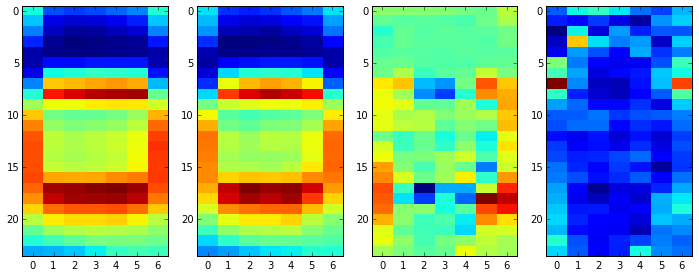

In [32]:
pred = reg.predict(Xtest) #put the predicted values into an array
hrInd=3 #the column number of the hr column
weekdayInd = 5 
weeklyPredict = np.zeros((24,7))
weeklyActual = np.zeros((24,7))

for i in range(0,len(ytest)):
    weeklyPredict[Xtest[i,hrInd], Xtest[i,weekdayInd]] += pred[i]
    weeklyActual[Xtest[i,hrInd], Xtest[i,weekdayInd]] += ytest[i]

def makeDifferencePlot(weeklyPredict, weeklyActual):
    plt.figure(1, figsize=(12,6))
    plt.subplot(141)
    plt.imshow(np.sqrt(weeklyPredict), interpolation='nearest', aspect=0.5)

    plt.subplot(142)
    plt.imshow(np.sqrt(weeklyActual), interpolation='nearest', aspect=0.5)

    plt.subplot(143)
    plt.imshow((weeklyPredict-weeklyActual), interpolation='nearest', aspect=0.5)

    plt.subplot(144)
    plt.imshow((weeklyPredict/weeklyActual), interpolation='nearest', aspect=0.5)

    plt.show()

makeDifferencePlot(weeklyPredict, weeklyActual)

This looks reasonable. Obviously not perfect, and the difference plot has some structure. The quotient is reasonably flat, though. This is also for the entire dataset - there may be more pronounced differences under certain conditions (ie, weather, temp, season, etc).

take a look at the same plots when the weather is good and the temp is high

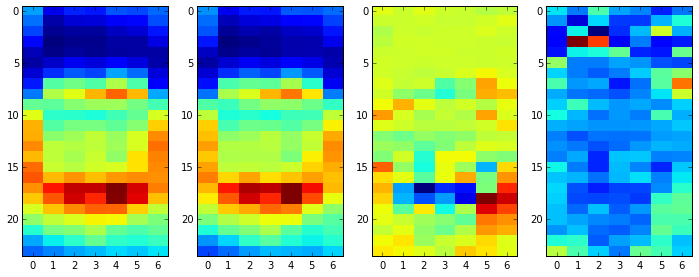

In [38]:
weeklyPredict = np.zeros((24,7))
weeklyActual = np.zeros((24,7))
weatherInd=7
atempInd = 9
for i in range(0,len(ytest)):
    if (Xtest[i, weatherInd] < 3 and Xtest[i,atempInd] > .6):
        weeklyPredict[Xtest[i,hrInd], Xtest[i,weekdayInd]] += pred[i]
        weeklyActual[Xtest[i,hrInd], Xtest[i,weekdayInd]] += ytest[i]

makeDifferencePlot(weeklyPredict, weeklyActual)

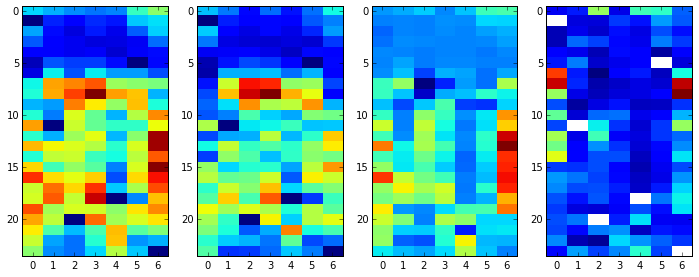

In [39]:
weeklyPredict = np.zeros((24,7))
weeklyActual = np.zeros((24,7))
weatherInd=7
atempInd = 9
for i in range(0,len(ytest)):
    if (Xtest[i, weatherInd] > 2 and Xtest[i,atempInd] < .6):
        weeklyPredict[Xtest[i,hrInd], Xtest[i,weekdayInd]] += pred[i]
        weeklyActual[Xtest[i,hrInd], Xtest[i,weekdayInd]] += ytest[i]

makeDifferencePlot(weeklyPredict, weeklyActual)

way overpredicting saturday rides in bad weather. 

###Now plot the learning curve

this method is lifted from the scikit-learn docs

In [40]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

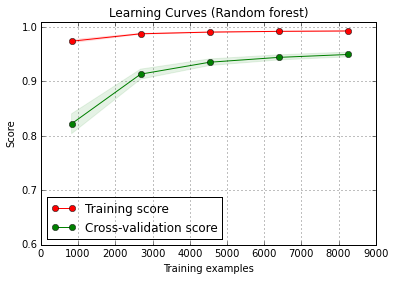

In [41]:
from sklearn.learning_curve import learning_curve
title = "Learning Curves (Random forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(len(Xtrain), n_iter=30,
                                   test_size=0.2, random_state=0)  
reg = RandomForestRegressor(n_estimators = 80)
plot_learning_curve(reg, title, Xtrain, ytrain, ylim=(0.6, 1.01), cv=cv, n_jobs=1)

In [43]:
plt.show()

this plot can be interpreted as needing more training data - it can also be interpreted as needing fewer features. That is to say, it does very well on the training set, but less so on the test set. So it's overfitting/has high variance.